In [12]:
# Install dependencies
!pip install tensorflow tensorflow-hub librosa pandas tqdm

# Imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import librosa
from tqdm import tqdm


In [13]:
# Clone ESC-50
!git clone https://github.com/karoldvl/ESC-50.git

# Load metadata
meta_df = pd.read_csv('ESC-50/meta/esc50.csv')
meta_df.head()


fatal: destination path 'ESC-50' already exists and is not an empty directory.


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [19]:
# Load YAMNet
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

# Function to extract embedding from audio
def extract_yamnet_embedding(wav_file, augment=False):
    waveform, sr = librosa.load(wav_file, sr=16000)  # YAMNet requires 16kHz
    waveform = waveform[:sr*10]  # cuts the audio to 10 seconds to avoid
    # memory overload
    scores, embeddings, spectrogram = yamnet_model(waveform)
    return tf.reduce_mean(embeddings, axis=0).numpy()

In [20]:
# This version creates 2X training data: original + augmented for each clip
embeddings = []
labels = []

for _, row in tqdm(meta_df.iterrows(), total=len(meta_df)):
    path = f"ESC-50/audio/{row['filename']}"
    try:
        # Original embedding
        emb_original = extract_yamnet_embedding(path, augment=False)
        embeddings.append(emb_original)
        labels.append(row['category'])

        # Augmented embedding
        emb_augmented = extract_yamnet_embedding(path, augment=True)
        embeddings.append(emb_augmented)
        labels.append(row['category'])

    except Exception as e:
        print(f"Failed on {path}: {e}")
        continue



100%|██████████| 2000/2000 [00:50<00:00, 39.53it/s]


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Prepare dataset
X = np.array(embeddings)
y = LabelEncoder().fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
# Define classifier
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(50, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3588 - loss: 3.0123 - val_accuracy: 0.7200 - val_loss: 1.2279
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6974 - loss: 1.2741 - val_accuracy: 0.7688 - val_loss: 0.9545
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7572 - loss: 0.9620 - val_accuracy: 0.8050 - val_loss: 0.7616
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7807 - loss: 0.8195 - val_accuracy: 0.8175 - val_loss: 0.6697
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8156 - loss: 0.7089 - val_accuracy: 0.8450 - val_loss: 0.6091
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8245 - loss: 0.6524 - val_accuracy: 0.8525 - val_loss: 0.5842
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8415 - loss: 0.6008 - val_accuracy: 0.8250 - val_loss: 0.6119
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8348 - loss: 0.6087 - val_accuracy: 0.

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


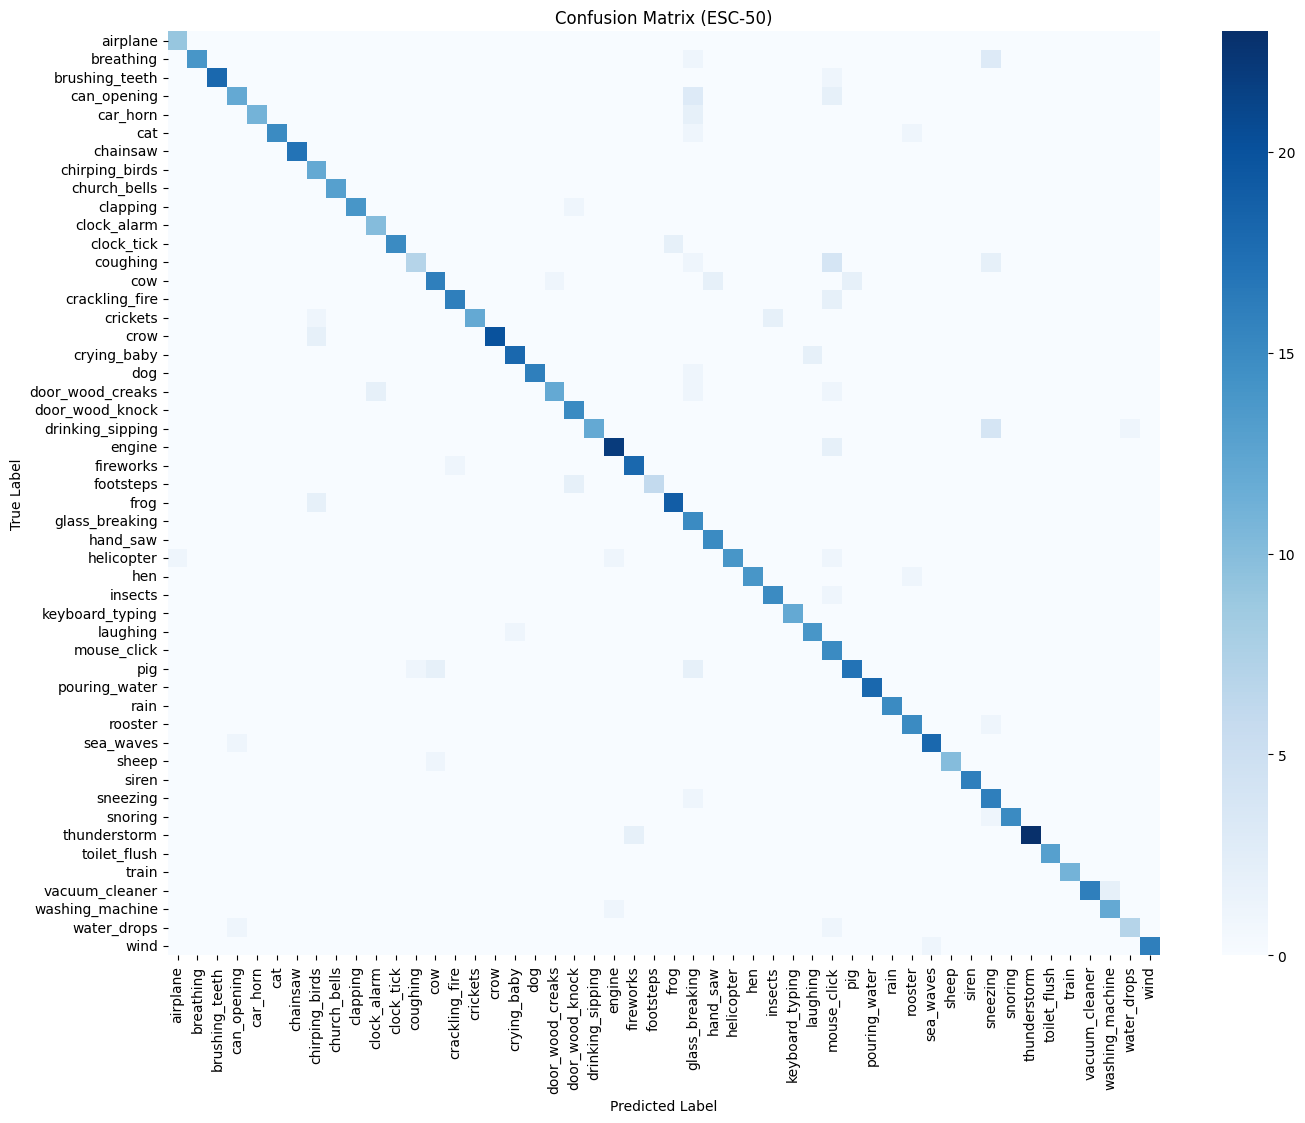

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict labels
y_pred = model.predict(X_test).argmax(axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels_unique = np.unique(labels)

# Plot
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=labels_unique, yticklabels=labels_unique)
plt.title("Confusion Matrix (ESC-50)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [24]:
# Detailed per-class precision, recall, F1-score
print(classification_report(y_test, y_pred, target_names=np.unique(labels)))


                  precision    recall  f1-score   support

        airplane       0.90      1.00      0.95         9
       breathing       1.00      0.78      0.88        18
  brushing_teeth       1.00      0.95      0.97        19
     can_opening       0.86      0.71      0.77        17
        car_horn       1.00      0.85      0.92        13
             cat       1.00      0.88      0.94        17
        chainsaw       1.00      1.00      1.00        17
  chirping_birds       0.71      1.00      0.83        12
    church_bells       1.00      1.00      1.00        13
        clapping       1.00      0.93      0.97        15
     clock_alarm       0.83      1.00      0.91        10
      clock_tick       1.00      0.88      0.94        17
        coughing       0.88      0.50      0.64        14
             cow       0.84      0.76      0.80        21
  crackling_fire       0.94      0.89      0.91        18
        crickets       1.00      0.80      0.89        15
            c

In [25]:
model.save("esc50_yamnet_model.h5") # saved for model real-time classification


# **Real-Time Classification**

In [26]:

!pip install gradio soundfile


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 134.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.8 MB/s eta 0:00:00


In [27]:
import gradio as gr
import tensorflow_hub as hub
import librosa
import numpy as np
import tensorflow as tf

# Load YAMNet again
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# Load your trained classifier
classifier = tf.keras.models.load_model("esc50_yamnet_model.h5")  # Or whatever you named it

# Load your label encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(labels)  # Use the same labels list you trained with

# Inference function
def classify_audio(audio):
    waveform, sr = librosa.load(audio, sr=16000)
    waveform = waveform[:sr*10]  # Limit to 10 sec
    scores, embeddings, spectrogram = yamnet_model(waveform)
    embedding = tf.reduce_mean(embeddings, axis=0).numpy()
    prediction = classifier.predict(np.expand_dims(embedding, axis=0)).argmax()
    label = label_encoder.inverse_transform([prediction])[0]
    return label

# Build Gradio interface
# The 'source' argument has been removed and is no longer necessary.
# The 'type' argument should be "filepath" to receive audio data as a temporary file path.
interface = gr.Interface(
    fn=classify_audio,
    inputs=gr.Audio(type="filepath"),  # Changed to gr.Audio(type="filepath")
    outputs="label",
    title="Real-Time ESC-50 Classifier",
    description="Speak or upload a sound. The model will classify it based on the ESC-50 dataset."
)

# Launch
interface.launch(debug=False)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3a4c58629de55e77c4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
